# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import torch
import collections
from ddpg_agent import Agent

In [6]:
agent = Agent(state_size, action_size, num_agents, 0)

In [8]:
def ddpg_train(max_episodes=1000, eps_initial=1.0, eps_end=0.05, eps_decay=0.99):
       
    scores_history = []                                           # for plotting graph
    scores_window = collections.deque(maxlen=100)                 # for keeping last 100 scores
    eps = eps_initial                                             # start of eps noise factor
    training_complete = False
    episode = 1
    
    while episode < max_episodes + 1:
        
        agent.reset()                                             # reset the agent for noise
        env_info = env.reset(train_mode=True)[brain_name]         # reset the environment
        states = env_info.vector_observations                     # get the current state (for each agent)
        ep_scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        step = 0

        episode_running = True                                    # flag for breaking the loop
        while episode_running:
            step = step + 1
            actions = agent.act(states, 1.0)                      # select an action (for each agent)
            env_info = env.step(actions)[brain_name]              # send all actions to tne environment
            next_states = env_info.vector_observations            # get next state (for each agent)
            rewards = env_info.rewards                            # get reward (for each agent)
            dones = env_info.local_done                           # see if episode finished
            ep_scores += env_info.rewards                         # update the score (for each agent)
            
            if len(scores_history) > 0:
                if scores_history[-1] > 35 and (not training_complete):
                    print("\rTraining complete since the score is already quite high")
                    training_complete = True

            if not training_complete:
                agent.step(states,actions,rewards,next_states,dones)  # agent to update with env info
            
            states = next_states                                  # roll over states to next time step
            if np.any(dones):                                     # exit loop if ANY episode finished
                episode_running = False
                
            #print("\rstep: ", step, end="")

        if agent.training_started == True:        
            scores_history.append(np.max(ep_scores))             # append episodic avg score to history
            scores_window.append(np.max(ep_scores))

            if len(scores_history)%100 == 0:
                print('\rEpisode: {}  Avg score: {:.2f}'.format(episode, np.mean(scores_history[-100:])))

            if len(scores_window) >=100 and np.mean(scores_window) >= .5:
                dicts_to_save = {'model_actor': agent.actor_local.state_dict(), 
                                 'model_critic': agent.critic_local.state_dict()}
                torch.save(dicts_to_save, 'agent.pt')
                print('\nEnvironment solved!\tAverage Score in last 100 episodes: {:.4f}'.format(np.mean(scores_window)))

                break

            episode += 1
            eps = max(eps*eps_decay,eps_end)
        

    env.close()
        
    return scores_history

scores_history = ddpg_train(5000)

Starting training
Episode: 100  Avg score: 0.00
Episode: 200  Avg score: 0.00
Episode: 300  Avg score: 0.00
Episode: 400  Avg score: 0.00
Episode: 500  Avg score: 0.02
Episode: 600  Avg score: 0.02
Episode: 700  Avg score: 0.03
Episode: 800  Avg score: 0.09
Episode: 900  Avg score: 0.11
Episode: 1000  Avg score: 0.11
Episode: 1100  Avg score: 0.19
Episode: 1200  Avg score: 0.30
Episode: 1300  Avg score: 0.25
Episode: 1400  Avg score: 0.23
Episode: 1500  Avg score: 0.22
Episode: 1600  Avg score: 0.34
Episode: 1700  Avg score: 0.34
Episode: 1800  Avg score: 0.36
Episode: 1900  Avg score: 0.37
Episode: 2000  Avg score: 0.46
Episode: 2100  Avg score: 0.38
Episode: 2200  Avg score: 0.33
Episode: 2300  Avg score: 0.40
Episode: 2400  Avg score: 0.44
Episode: 2500  Avg score: 0.41
Episode: 2600  Avg score: 0.41
Episode: 2700  Avg score: 0.40
Episode: 2800  Avg score: 0.42
Episode: 2900  Avg score: 0.50

Environment solved!	Average Score in last 100 episodes: 0.5039


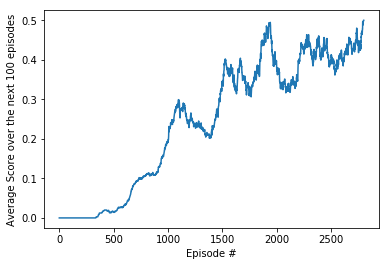

In [14]:
import matplotlib.pyplot as plt

averaged_score_history = []
for i in range(0, len(scores_history) - 100):
    averaged_score_history.append(np.mean(scores_history[i:i+100]))
plt.plot(np.arange(len(averaged_score_history)), averaged_score_history)
plt.ylabel('Average Score over the next 100 episodes')
plt.xlabel('Episode #')
plt.show()